# Data used in tutorial can be found below

data: https://o365coloradoedu-my.sharepoint.com/:u:/g/personal/kinderp_colorado_edu/EYiGDoOBfqxAq4CflozA1HMBpOKRLc3MnliH2iU3jnD38g?e=W8IQRU

Download the data and then upload the zip in the cell below:


In [9]:
from google.colab import files

uploaded = files.upload()

Saving data.zip to data.zip


Then install unzip

In [10]:
!apt install unzip

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.2).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


Then unzip data file

In [11]:
!unzip data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/train/7/AVY_Bullish_CDLMATCHINGLOW_2022_10_10.png  
  inflating: data/train/7/AVY_Bullish_CDLMATCHINGLOW_2023_04_21.png  
  inflating: data/train/7/AVY_Bullish_CDLMATCHINGLOW_2023_12_06.png  
  inflating: data/train/7/AWK_Bullish_CDLMATCHINGLOW_2010_10_18.png  
  inflating: data/train/7/AWK_Bullish_CDLMATCHINGLOW_2011_06_16.png  
  inflating: data/train/7/AWK_Bullish_CDLMATCHINGLOW_2011_12_06.png  
  inflating: data/train/7/AWK_Bullish_CDLMATCHINGLOW_2012_05_04.png  
  inflating: data/train/7/AWK_Bullish_CDLMATCHINGLOW_2012_08_02.png  
  inflating: data/train/7/AWK_Bullish_CDLMATCHINGLOW_2013_04_24.png  
  inflating: data/train/7/AWK_Bullish_CDLMATCHINGLOW_2013_07_29.png  
  inflating: data/train/7/AWK_Bullish_CDLMATCHINGLOW_2013_07_31.png  
  inflating: data/train/7/AWK_Bullish_CDLMATCHINGLOW_2015_06_22.png  
  inflating: data/train/7/AWK_Bullish_CDLMATCHINGLOW_2017_04_07.png  
  inflating: data/train/7/AWK_Bullish_C

# Import Libraries and Modules

In [5]:
pip install datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.0 MB/s eta 0:00:00


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import shutil
import os

# Positional Embedding

In [13]:
class PositionalEmbedding(nn.Module):
  def __init__(self, width, max_seq_length):
    super().__init__()

    # Creating positional encoding
    pe = torch.zeros(max_seq_length, width)

    for pos in range(max_seq_length):
      for i in range(width):
        if i % 2 == 0:
          pe[pos][i] = np.sin(pos/(10000 ** (i/width)))
        else:
          pe[pos][i] = np.cos(pos/(10000 ** ((i-1)/width)))

    self.register_buffer('pe', pe.unsqueeze(0))

  def forward(self, x):
    # Add positional encoding to embeddings
    x = x + self.pe

    return x

# Multi-Head Attention

In [14]:
class AttentionHead(nn.Module):
  def __init__(self, width, head_size):
    super().__init__()
    self.head_size = head_size

    self.query = nn.Linear(width, head_size)
    self.key = nn.Linear(width, head_size)
    self.value = nn.Linear(width, head_size)

  def forward(self, x, mask=None):
    # Obtaining Queries, Keys, and Values
    Q = self.query(x)
    K = self.key(x)
    V = self.value(x)

    # Dot Product of Queries and Keys
    attention = Q @ K.transpose(-2,-1)

    # Scaling
    attention = attention / (self.head_size ** 0.5)

    # Applying Attention Mask
    if mask is not None:
        attention = attention.masked_fill(mask == 0, float("-inf"))

    attention = torch.softmax(attention, dim=-1)

    attention = attention @ V

    return attention

In [15]:
class MultiHeadAttention(nn.Module):
  def __init__(self, width, n_heads):
    super().__init__()
    self.head_size = width // n_heads

    self.W_o = nn.Linear(width, width)

    self.heads = nn.ModuleList([AttentionHead(width, self.head_size) for _ in range(n_heads)])

  def forward(self, x, mask=None):
    # Combine attention heads
    out = torch.cat([head(x, mask=mask) for head in self.heads], dim=-1)

    out = self.W_o(out)

    return out

# Transformer Encoder

In [16]:
class TransformerEncoder(nn.Module):
    def __init__(self, width, n_heads, r_mlp=4):
        super().__init__()
        self.width = width
        self.n_heads = n_heads

        # Sub-Layer 1 Normalization
        self.ln1 = nn.LayerNorm(width)

        # Multi-Head Attention
        self.mha = MultiHeadAttention(width, n_heads)

        # Sub-Layer 2 Normalization
        self.ln2 = nn.LayerNorm(width)

        # Multilayer Perception
        self.mlp = nn.Sequential(
            nn.Linear(self.width, self.width*r_mlp),
            nn.GELU(),
            nn.Linear(self.width*r_mlp, self.width)
        )


    def forward(self, x, mask=None):
        # Residual Connection After Sub-Layer 1
        x = x + self.mha(self.ln1(x), mask=mask)

        # Residual Connection After Sub-Layer 2
        x = x + self.mlp(self.ln2(x))

        return x

# Tokenizer

In [17]:
def tokenizer(text, encode=True, mask=None, max_seq_length=60):
    if encode:
        out = chr(2) + text + chr(3) # Adding SOT and EOT tokens
        out = out + "".join([chr(0) for _ in range(max_seq_length-len(out))]) # Adding Padding
        out = torch.IntTensor(list(out.encode("utf-8"))) # Encoding Text
        mask = torch.ones(len(out.nonzero()))
        mask = torch.cat((mask,torch.zeros(max_seq_length-len(mask)))).type(torch.IntTensor)
    else:
        out = [chr(x) for x in text[1:len(mask.nonzero())-1]]
        out = "".join(out)
        mask = None

    return out, mask

# Text Encoder

In [18]:
class TextEncoder(nn.Module):
    def __init__(self, vocab_size, width, max_seq_length, n_heads, n_layers, emb_dim):
        super().__init__()

        self.max_seq_length = max_seq_length  # Maximum length of input sequence

        self.encoder_embedding = nn.Embedding(vocab_size, width) # Embedding Table

        self.positional_embedding = PositionalEmbedding(width, max_seq_length)

        self.encoder = nn.ModuleList([TransformerEncoder(width,n_heads) for _ in range(n_layers)])

        # learned proj of image to embed
        self.projection = nn.Parameter(torch.randn(width, emb_dim))

    def forward(self, text, mask=None):
        # Text Embedding
        x = self.encoder_embedding(text)

        # Positional Embedding
        x = self.positional_embedding(x)

        # Transformer Encoder
        for encoder_layer in self.encoder:
            x = encoder_layer(x, mask=mask)

        # Takes features from the EOT Embedding
        x = x[torch.arange(text.shape[0]),torch.sub(torch.sum(mask[:,0],dim=1),1)]

        # joint multimodal embedding
        if self.projection is not None:
            x = x @ self.projection

        x = x / torch.norm(x, dim=-1, keepdim=True)

        return x

# Image Encoder

In [19]:
class ImageEncoder(nn.Module):
    def __init__(self, width, img_size, patch_size, n_channels, n_layers, n_heads, emb_dim):
        super().__init__()

        assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0, "img_size dimensions must be divisible by patch_size dimensions"
        assert width % n_heads == 0, "width must be divisible by n_heads"

        self.n_patches = (img_size[0] * img_size[1]) // (patch_size[0] * patch_size[1])

        self.max_seq_length = self.n_patches + 1

        # Patch Embedding
        self.linear_project = nn.Conv2d(n_channels, width, kernel_size=patch_size, stride=patch_size)

        # Classification Token
        self.cls_token = nn.Parameter(torch.randn(1, 1, width))

        self.positional_embedding = PositionalEmbedding(width,self.max_seq_length)

        self.encoder = nn.ModuleList([TransformerEncoder(width,n_heads) for _ in range(n_layers)])

        # learned proj of image to embed
        self.projection = nn.Parameter(torch.randn(width, emb_dim))


    def forward(self,x):
        # Patch Embedding
        x = self.linear_project(x)
        x = x.flatten(2).transpose(1, 2)

        # Positional Embedding
        x = torch.cat((self.cls_token.expand(x.size()[0], -1, -1),x), dim=1)
        x = self.positional_embedding(x)

        # Transformer Encoder
        for encoder_layer in self.encoder:
            x = encoder_layer(x)

        # Takes Class Tokens
        x = x[:, 0, :]

        # joint multimodal embedding
        if self.projection is not None:
            x = x @ self.projection

        x = x / torch.norm(x, dim=-1, keepdim=True)

        return x


# CLIP Model

In [20]:
class CLIP(nn.Module):
    def __init__(self, emb_dim, vit_width, img_size, patch_size, n_channels, vit_layers, vit_heads, vocab_size, text_width, max_seq_length, text_heads, text_layers):
        super().__init__()

        self.image_encoder = ImageEncoder(vit_width, img_size, patch_size, n_channels, vit_layers, vit_heads, emb_dim)

        self.text_encoder = TextEncoder(vocab_size, text_width, max_seq_length, text_heads, text_layers, emb_dim)

        self.temperature = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    def forward(self,image,text, mask=None):
        I_e = self.image_encoder(image)
        T_e = self.text_encoder(text, mask=mask)

        # scaled pairwise cosine similarities [n, n]
        logits = (I_e @ T_e.transpose(-2,-1)) * torch.exp(self.temperature)

        # symmetric loss function
        labels = torch.arange(logits.shape[0]).to(self.device)

        loss_i = nn.functional.cross_entropy(logits.transpose(-2,-1), labels)
        loss_t = nn.functional.cross_entropy(logits, labels)

        loss = (loss_i + loss_t) / 2

        return loss

# Dataset

In [22]:
captions = {0: "A bearish tasuki gap pattern",
            1: "A bearish downside gap three methods pattern",
            2: "A bullish engulfing pattern",
            3: "A bullish gap side by side white lines pattern",
            4: "A bullish hikkake pattern",
            5: "A bullish three line strike pattern",
            6: "A bullish three outside up pattern",
            7: "A bullish matching low pattern",
            8: "A bullish stick sandwich pattern",
            9: "A bullish tasuki gap pattern",
            10: "A bullish upside gap three methods pattern",
            11: "A bearish three line strike pattern",
            12: "A bearish three outside down pattern",
            13: "A bearish engulfing pattern",
            14: "A bearish gap side by side white lines pattern",
            15: "A bearish hikkake pattern",}

In [26]:
class CandlestickPattern(Dataset):
    def __init__(self, train=True):
        self.dataset = load_dataset("data")

        self.transform = T.ToTensor()

        if train:
            self.split = "train"
        else:
            self.split = "test"

        self.captions = captions

    def __len__(self):
        return self.dataset.num_rows[self.split]

    def __getitem__(self,i):
        img = self.dataset[self.split][i]["image"]
        img = self.transform(img)
        img = img[:, 4:-4, :]
        img = torch.cat((torch.ones(img.shape[0], img.shape[1], 1), img, torch.ones(img.shape[0], img.shape[1], 1)), dim=2)

        cap, mask = tokenizer(self.captions[self.dataset[self.split][i]["label"]])

        mask = mask.repeat(len(mask),1)

        return {"image": img, "caption": cap, "mask": mask}

# Training Parameters

In [24]:
emb_dim = 128
vit_width = 12
img_size = (260,120)
patch_size = (20,12)
n_channels = 1
vit_layers = 6
vit_heads = 6
vocab_size = 256
text_width = 64
max_seq_length = 60
text_heads = 8
text_layers = 4
lr = 1e-3
epochs = 50
batch_size = 64

# Loading Dataset

In [27]:
train_set = CandlestickPattern(train=True)
test_set = CandlestickPattern(train=False)

train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size)

Resolving data files:   0%|          | 0/31357 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1655 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/31357 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1655 [00:00<?, ?it/s]

In [28]:
print(train_set[0]["image"].shape)
print(train_set[0]["caption"].shape)
print(train_set[0]["mask"].shape)
print(train_set[0]["caption"])
print(train_set[0]["mask"])

torch.Size([1, 260, 120])
torch.Size([60])
torch.Size([60, 60])
tensor([  2,  65,  32,  98, 101,  97, 114, 105, 115, 104,  32, 116,  97, 115,
        117, 107, 105,  32, 103,  97, 112,  32, 112,  97, 116, 116, 101, 114,
        110,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0], dtype=torch.int32)
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32)


# Training

Training can take a while, so you can download the model weights from the tutorial here: https://o365coloradoedu-my.sharepoint.com/:u:/g/personal/kinderp_colorado_edu/EQZzlS61K8JLv_zrFroP3sYBRgE0eOpQ7afZyje_EGXf9g?e=tP85Kn

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

model = CLIP(emb_dim, vit_width, img_size, patch_size, n_channels, vit_layers, vit_heads, vocab_size, text_width, max_seq_length, text_heads, text_layers).to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)

best_loss = np.inf
train_losses = []
for epoch in range(epochs):
    model.train()
    train_loss = []
    for i, data in enumerate(train_loader, 0):
        img, cap, mask = data["image"].to(device), data["caption"].to(device), data["mask"].to(device)
        loss = model(img,cap,mask)
        train_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses.append(np.mean(train_loss))

    # Saves model if it performed better than the previous best
    print(f'Epoch: [{epoch + 1}/{epochs}], Train Loss: {train_losses[-1]}')
    if train_losses[-1] <= best_loss:
        best_loss = train_losses[-1]
        torch.save(model.state_dict(), "model/clip.pt")
        print("Model Saved.")

Using device:  cuda (NVIDIA GeForce RTX 4090)
Epoch: [1/50], Train Loss: 3.5257199919953637
Model Saved.
Epoch: [2/50], Train Loss: 2.697098750484233
Model Saved.
Epoch: [3/50], Train Loss: 2.4967429083220813
Model Saved.
Epoch: [4/50], Train Loss: 2.3894858939307078
Model Saved.
Epoch: [5/50], Train Loss: 2.32605155098195
Model Saved.
Epoch: [6/50], Train Loss: 2.273409867286682
Model Saved.
Epoch: [7/50], Train Loss: 2.2237037726811
Model Saved.
Epoch: [8/50], Train Loss: 2.180829447386216
Model Saved.
Epoch: [9/50], Train Loss: 2.1452779460926443
Model Saved.
Epoch: [10/50], Train Loss: 2.123361870950582
Model Saved.
Epoch: [11/50], Train Loss: 2.098788226867209
Model Saved.
Epoch: [12/50], Train Loss: 2.081130645956312
Model Saved.
Epoch: [13/50], Train Loss: 2.0644552041073236
Model Saved.
Epoch: [14/50], Train Loss: 2.044726252555847
Model Saved.
Epoch: [15/50], Train Loss: 2.0400071881255326
Model Saved.
Epoch: [16/50], Train Loss: 2.0270579637313375
Model Saved.
Epoch: [17/50],

# Testing

In [ ]:
# Loading Best Model
model = CLIP(emb_dim, vit_width, img_size, patch_size, n_channels, vit_layers, vit_heads, vocab_size, text_width, max_seq_length, text_heads, text_layers).to(device)
model.load_state_dict(torch.load("model/clip.pt", map_location=device))
model.eval()

# Getting dataset captions to compare images to
text = torch.stack([tokenizer(x)[0] for x in test_set.captions.values()]).to(device)
mask = torch.stack([tokenizer(x)[1] for x in test_set.captions.values()])
mask = mask.repeat(1,len(mask[0])).reshape(len(mask),len(mask[0]),len(mask[0])).to(device)

correct, total = 0,0
with torch.no_grad():
    for data in test_loader:
        images, labels = data["image"].to(device), data["caption"].to(device)
        image_features = model.image_encoder(images)
        text_features = model.text_encoder(text, mask=mask)

        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * (image_features @ text_features.T)).softmax(dim=-1)
        _, indices = torch.max(similarity,1)
        pred = torch.stack([tokenizer(test_set.captions[int(i)])[0] for i in indices]).to(device)
        correct += int(sum(torch.sum((pred==labels),dim=1)//len(pred[0])))
        total += len(labels)

print(f'\nModel Accuracy: {100 * correct // total} %')


Model Accuracy: 85 %


# Zero-Shot Classification

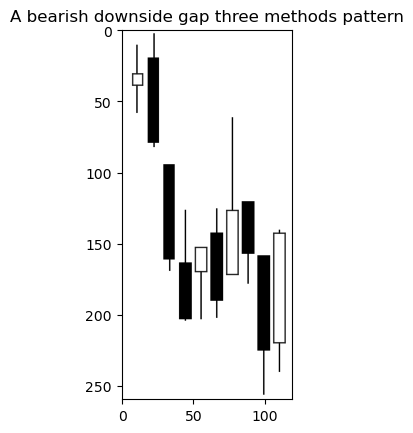


Top predictions:

A bearish downside gap three methods pattern: 100.00%
A bearish tasuki gap pattern: 0.00%
A bullish stick sandwich pattern: 0.00%
A bullish three outside up pattern: 0.00%
A bullish matching low pattern: 0.00%


In [ ]:
# Loading Best Model
model = CLIP(emb_dim, vit_width, img_size, patch_size, n_channels, vit_layers, vit_heads, vocab_size, text_width, max_seq_length, text_heads, text_layers).to(device)
model.load_state_dict(torch.load("model/clip.pt", map_location=device))


# Captions to compare images to
class_names = list(captions.values())

text = torch.stack([tokenizer(x)[0] for x in class_names]).to(device)
mask = torch.stack([tokenizer(x)[1] for x in class_names])
mask = mask.repeat(1,len(mask[0])).reshape(len(mask),len(mask[0]),len(mask[0])).to(device)

idx = 200

img = test_set[idx]["image"][None,:]
plt.imshow(  img[0].cpu().permute(1, 2, 0)  ,cmap="gray")
plt.title(tokenizer(test_set[idx]["caption"], encode=False, mask=test_set[idx]["mask"][0])[0])
plt.show()
img = img.to(device)
with torch.no_grad():
  image_features = model.image_encoder(img)
  text_features = model.text_encoder(text, mask=mask)


image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{class_names[int(index)]:>16s}: {100 * value.item():.2f}%")